In [1]:
import numpy as np
import pandas as pd

import pygsheets

from datetime import datetime

import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt

import time
import string
import pickle

from sklearn.preprocessing import StandardScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy.stats import pearsonr

from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

import statsmodels.formula.api as smf

from lifelines import KaplanMeierFitter


/Users/lukasbierfreund/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [111]:
# Anonymized Variable Names

# Independent Variables
INDEPENDENT_VARIABLES = [
    'indep_var_A',  # indep_var_A
    'indep_var_B',  # indep_var_B
    'indep_var_C',  # indep_var_C
    'indep_var_D',  # indep_var_D
    'indep_var_E',  # indep_var_E
    'indep_var_F'   # indep_var_F
]

# Control Variables
CONTROL_VARIABLES = [
    'control_var_A',  # t_in_portfolio
    'control_var_B',  # control_var_B
    'control_var_D',  # control_var_C
    'control_var_D',  # control_var_D
    'control_var_E',  # control_var_E
    'control_var_F'   # control_var_F
]

# Dependent Variables
DEPENDENT_VARIABLES = [
    'dep_var_A',  # follow_on
    'dep_var_B'   # survived
]

# Venture Development Variables
VENTURE_DEVELOPMENT_VARIABLES = [
    'vd_var_A',  # vd_var_A
    'vd_var_B',  # vd_var_B
    'vd_var_C'   # vd_var_C
]

# Features
FEATURES = INDEPENDENT_VARIABLES + CONTROL_VARIABLES
FEATURES_INCL_DEP = FEATURES + DEPENDENT_VARIABLES

# Time-Based Ranges
NUM_MONTHS = 19
MONTH_RANGE = range(NUM_MONTHS)

# Anonymized Independent Variables across months
INDEPENDENT_VARS = {
    i: [f"{var}_{i}" for var in INDEPENDENT_VARIABLES] for i in range(NUM_MONTHS)
}

In [112]:
data_path = "../data/"

with open(data_path + 'portfolio_anonymized.pkl','rb') as inputfile:
    portfolio = pickle.load(inputfile)
    
with open(data_path + 'transaction_data_anonymized.pkl','rb') as inputfile:
    transaction_data = pickle.load(inputfile)
    
with open(data_path + 'company_metadata_anonymized.pkl','rb') as inputfile:
    company_metadata = pickle.load(inputfile)
    

In [113]:
portfolio.columns

Index(['company', 'month', 'wk_order', 'indep_var_A', 'indep_var_B',
       'indep_var_C', 'indep_var_D', 'indep_var_E', 'indep_var_F',
       'cluster_main', 'control_var_B', 'vd_var_A', 'vd_var_B', 'vd_var_C',
       'first_investment', 'investment_eur', 'round_name',
       'transaction_month'],
      dtype='object')

In [114]:
print(f'Number of unique companies in the sample = {len(portfolio.company.unique())})')

Number of unique companies in the sample = 135)


In [115]:
# removing the companies that were in the data but the financing rounds didn't close in the end
portfolio_removed = portfolio[portfolio['company'].isin(portfolio[portfolio.wk_order == 34].index)==False]
portfolio = portfolio[portfolio['company'].isin(portfolio[portfolio.wk_order == 34].index)]
print(list(portfolio_removed.index.unique()), ' were removed, as the financing rounds were not closed, thus the companies are not part of the portfolio.')


['Company 002', 'Company 067', 'Company 084']  were removed, as the financing rounds were not closed, thus the companies are not part of the portfolio.


In [117]:
def months_between(start, end):
    return (end.year - start.year) * 12 + (end.month - start.month)

In [179]:
def describe_company(cd, print_name = False):
    INDEPENDENT_VARIABLES = ['indep_var_A','indep_var_B','indep_var_C','indep_var_D','indep_var_E','indep_var_F']
    THRESHOLD_SCORE_WK_ORDER = 14

    
    if isinstance(cd, pd.Series):
        print(f'{cd.company} skipped because it just entered the portfolio this month')
        return 
    if len(cd.company.unique()) > 1:
        raise Exception(f"More than one company in cd: {cd.company.unique()}")
     
    company = {}
    
    name = cd.company.unique()[0]
    company['name'] = name
    if print_name:
        print(name)
    
    # first month where the company is scored 
    first_month = cd[(cd.indep_var_D.notna()) & (cd.indep_var_E.notna())].iloc[0].month
    company['first_month'] = cd[(cd.indep_var_D.notna()) & (cd.indep_var_E.notna())].iloc[0].month
    
    # getting the first investment month, which differs from the first month with a score
    first_investment = cd[(cd['first_investment'].notnull()) & (cd['first_investment'] != '#N/A')].iloc[0]['first_investment']
    
    if first_investment != 'not closed':
        company['first_investment'] = datetime.strptime(first_investment,'%m/%d/%Y')
        
    else:
        # if the first investment is 'not closed' yet, we will consider the first investment to be the first month with a score
        company['first_investment'] = company['first_month']#first_investment
    
    
    # Was the first investment during the time of the Accelerator or the pure VC
    if company['first_investment'] > datetime.strptime(f'2021-01-01','%Y-%m-%d'):
        company['control_var_F'] = 1
        
        # Post Accelerator time the venture development period is 6 weeks
        company['joined_portfolio'] = company['first_month'] - np.timedelta64(6, 'W')
        
    else:
        company['control_var_F'] = 0
        
        # during accelerator times the venture development was 100 days
        company['joined_portfolio'] = company['first_month'] - np.timedelta64(100, 'D')
    
    # how long has the company been in the portfolio (measured since the month of joining the portfolio)
    company['t_in_portfolio'] = months_between(company['joined_portfolio'] , datetime.strptime('03/22','%m/%y'))
    
    cluster_values = cd["cluster_main"].values
    
    if "Exit" in cluster_values:
        exit_month = cd[cd.cluster_main == 'Exit'].iloc[0].month
        company['exit'] = exit_month
        company['exit_t'] = months_between(company['joined_portfolio'], exit_month)
    
    if "Out" in cluster_values:
        shutdown_month = cd[cd.cluster_main == 'Out'].iloc[0].month
        company['shutdown'] = shutdown_month
        company['shutdown_t'] = months_between(company['joined_portfolio'], shutdown_month)
        
        # add survival status per company into the frame
        company["survived"] = 0
        
    elif cd[INDEPENDENT_VARIABLES].isin([0]).any().any():
        for index, row in cd.iterrows():
            val_counts = row[INDEPENDENT_VARIABLES].value_counts()
            if 0 in val_counts and row.wk_order > THRESHOLD_SCORE_WK_ORDER:
                if val_counts[0] >= 3:
                    company["survived"] = 0
                    shutdown_month = row.month
                    company['shutdown'] = shutdown_month
                    company['shutdown_t'] = months_between(company['joined_portfolio'], shutdown_month)
                    company['more_than_3_zeroes'] = shutdown_month 
                    break
            else:
                company["survived"] = 1
    else:
        company["survived"] = 1
    
    company["control_var_B"] = cd["control_var_B"].iloc[0]
    
    company['first_month_w_data'] = cd[(cd.indep_var_D.isna() == False) & (cd['indep_var_E'].isna() == False)].iloc[0].month
    
    
    company['cluster_main'] = cd[cd.indep_var_D.isna() == False].iloc[0].cluster_main
    company['cluster_main_6'] = cd[(cd.indep_var_D.isna() == False) & (cd['indep_var_E'].isna() == False)].iloc[6].cluster_main if len(cd) >= 7 else None
    

    
    # add the age of the datapoints (i.e. time between first month in the portfolio and first scoring on the 6-point scale)
    company['data_point_age'] = months_between(company['first_month'],company['first_month_w_data'])
    
    financing_data = cd[(cd.round_name.isnull() == False) 
                        & (cd.round_name.isin(['Accelerator','Pre-APX','nan']) == False) 
                        & (cd.transaction_month > (pd.to_datetime(company['first_investment']) + pd.DateOffset(months=0)))]  # ['Accelerator','Pre-APX','Bridge2', 'Bridge1', 'Bridge3', 'Bridge4', 'Bridge5']
    if len(financing_data) > 0:
        company['follow_on'] = 1
        
        follow_on_month = financing_data.iloc[0].transaction_month

        company['follow_on_month'] = follow_on_month
        
        company['t_follow_on'] = months_between(company['joined_portfolio'], follow_on_month)#months_between(company['first_investment'],follow_on_month)
        company['t_follow_on_since_invest'] = months_between(company['first_investment'], follow_on_month)
        round_name = financing_data.iloc[0].round_name
        
        #if np.isnan(round_name) == False:
        if 'Bridge' in round_name:
            round_name = 'Bridge'
        if 'Seed' in round_name:
            round_name = 'Seed'
        if 'Series-A' in round_name:
            round_name = 'Series_A'
        company['round_name'] = round_name
        company['round_size'] = financing_data.iloc[0].investment_eur
    else:
        company['follow_on'] = 0
        company['round_size'] = np.nan


    temp = cd[(cd.indep_var_D.isna() == False) & (cd['indep_var_E'].isna() == False)]
    for i in MONTH_RANGE:
        if len(temp) >= i+1:
            t = temp.iloc[i]
            
            # check if a shutdown_month is present and if so if the current loop's month is the shutdown month, if so then stop
            try:
                if shutdown_month:
                    if t.month == shutdown_month:
                        break
            except:
                pass
            for s in INDEPENDENT_VARIABLES + ['vd_var_A','vd_var_B','vd_var_C']:
                
                #print(t.month > shutdown_month, t.month)
                score = t[s]
                company[s+"_"+str(i)] = score * 5 if t.wk_order <= THRESHOLD_SCORE_WK_ORDER else score
            
                
    
    return company

In [180]:
# this function checks if the first month indep_var_F is missing and if so replaces it with the next earliest indep_var_F score
def get_earliest_indep_var_F(row, start_month = 0):
    if np.isnan(row[f'indep_var_F_{start_month}']):
        for i in MONTH_RANGE:
            liq = row[f'indep_var_F_{i}']
            if np.isnan(liq) == False:
                if liq != 0:
                    return liq - 0.5
                else:
                    return liq
    else:
        return row[f'indep_var_F_{start_month}']


# Regression on survival

In [182]:
# use the describe_company() function on each company to gather relevant information such as first month with useable data (e.g., after the 08/20 change in scoring)
pre_data = [describe_company(portfolio.loc[company],False) for company in portfolio.index.unique()]

# some companies will have been removed during the process due to having data only from before 08/20
pre_data = [x for x in pre_data if x is not None]

# set up an index for the data
pre_data_index = [x['name'] for x in pre_data]

# turn data into a dataframe
data = pd.DataFrame(pre_data, index=pre_data_index)


# Individual company changes
# Company 052 is the only company that has a NaN in indep_var_F, thus I use the average of its other scores to fill indep_var_F
data.at['Company 052','indep_var_F_0'] = np.average(data.loc['Company 052'][['indep_var_A_0','indep_var_B_0','indep_var_C_0','indep_var_D_0','indep_var_E_0']])
# Company 037's investment date is not correct according to Teddy, it is December of 2019 not May of 2019
data.at['Company 037','first_investment'] = pd.to_datetime(datetime(2019,12,1))

# for the few companies that did not get indep_var_F scored (in March 2019) we use the earliest available indep_var_F score
for i in range(3):
    data[f'indep_var_F_{i}'] = data.apply(lambda row: get_earliest_indep_var_F(row, i), axis=1)

data['t_until_first_scoring'] = data.apply(lambda row: months_between(row.first_investment, row.first_month), axis=1)


data['control_var_D'],data['control_var_C'] = None, None
for index, row in company_metadata.iterrows():
    if row.company in data.name:        
        
        data.loc[row.company, 'control_var_D'] = row.control_var_D if row.control_var_C != '-' else None
        data.loc[row.company, 'control_var_C'] = row.control_var_C if row.control_var_C!= '-' else None
        data.loc[row.company, 'control_var_E'] = 1 if row.control_var_C == "Germany" else 0
        
    else:
        print('not in company metadata: ', row.company)
        

Company 004 skipped because it just entered the portfolio this month
Company 042 skipped because it just entered the portfolio this month
Company 057 skipped because it just entered the portfolio this month
Company 135 skipped because it just entered the portfolio this month
not in company metadata:  Company 156
not in company metadata:  Company 157
not in company metadata:  Company 158
not in company metadata:  Company 057
not in company metadata:  Company 004
not in company metadata:  Company 042
not in company metadata:  Company 135
not in company metadata:  Company 159
not in company metadata:  Company 160
not in company metadata:  Company 155
not in company metadata:  Company 152
not in company metadata:  Company 139
not in company metadata:  Company 153
not in company metadata:  Company 161
not in company metadata:  Company 137
not in company metadata:  Company 149
not in company metadata:  Company 162
not in company metadata:  Company 163
not in company metadata:  Company 138
no

In [183]:
# When did the companies join the portfolio
print(f'Total considered portfolio size: {len(data)}')
print('Portfolio entry by year:')
for i in [2018, 2019, 2020, 2021, 2022]:
    start_date = pd.Timestamp(f'{i}-01-01')
    end_date = pd.Timestamp(f'{i}-12-31')
    num_companies = len(data[(data.first_investment > start_date) & (data.first_investment <= end_date)])
    print(i, num_companies, 'companies')


Total considered portfolio size: 128
Portfolio entry by year:
2018 8 companies
2019 30 companies
2020 35 companies
2021 50 companies
2022 4 companies


In [184]:
# Remove companies that joined the portfolio before the start of 2019
date_cutoff = np.datetime64('2019-01-01')
data = data[data['first_investment'] > date_cutoff]

In [185]:
print(f"{data[data.survived == 1].name.count()} surviving companies")
print(f"{data[data.survived == 0].name.count()} closed companies")

# Summary statistics for shutdown times of closed companies
print(data[data.shutdown_t.notna()].shutdown_t.describe())

94 surviving companies
26 closed companies
count    26.000000
mean     21.153846
std       8.355560
min       5.000000
25%      14.250000
50%      22.000000
75%      28.000000
max      36.000000
Name: shutdown_t, dtype: float64


In [186]:
print(f'{data[data.follow_on == 1].name.count()} received follow_on funding')
print(f'{data[data.follow_on == 0].name.count()} did not receive follow_on funding')


66 received follow_on
54 did not receive follow_on


### Correlation
For each company I am looking only at the first scoring under the 1-5 scale
TODO: need to check the time frames since entering the portfolio and the first measurement for each company

Variable Inflation Factor (VIF)

In [187]:
a = ['indep_var_C_0', 'indep_var_E_0','indep_var_A_0'] #5.78 to 8.73
a = ['indep_var_C_0', 'indep_var_E_0','indep_var_F_0'] # 4.57 to 6.37
a = ['indep_var_C_0', 'indep_var_E_0','indep_var_D_0'] # 6.12 to 8.82
a = ['indep_var_C_0', 'indep_var_E_0','indep_var_B_0'] # 4.99 to 7.75

In [222]:

# VIF for all independent variables
X = data[INDEPENDENT_VARS[0]]
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print("VIF with all independent variables")
print(vif_data.round(2))
print()

# VIF for traction, investor feedback, and indep_var_F variables only
selected_features = ['indep_var_C_0', 'indep_var_E_0', 'indep_var_F_0']
X = data[selected_features]
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print("VIF with only indep_var_C, indep_var_E, and indep_var_F")
print(vif_data.round(2))


VIF with all independent variables
         feature    VIF
0  indep_var_A_0  12.19
1  indep_var_B_0  12.80
2  indep_var_C_0   7.39
3  indep_var_D_0  12.05
4  indep_var_E_0   8.23
5  indep_var_F_0   7.30

VIF with only indep_var_C, indep_var_E, and indep_var_F
         feature   VIF
0  indep_var_C_0  4.57
1  indep_var_E_0  6.37
2  indep_var_F_0  5.48


# Factor analysis


### Determining the factorability of the dataset 
(i.e., can factors be found in the dataset)




In [192]:
#CHECK ADEQUACY
#Bartlett
#p-value should be 0 (statistically sig.)

chi_square_value, p_value = calculate_bartlett_sphericity(data[INDEPENDENT_VARS[0]])
print(f"Bartlett test: Chi_squared = {chi_square_value.round(4)} & p-value = {p_value.round(10)}")

#KMO
#Value should be >0.6
kmo_all, kmo_model = calculate_kmo(data[INDEPENDENT_VARS[0]].dropna())
print(f"Kaiser-Meyer-Olkin (KMO) test = {kmo_model.round(4)}")

Bartlett test: Chi_squared = 135.2179 & p-value = 0.0
Kaiser-Meyer-Olkin (KMO) test = 0.7346


### Choosing the number of factors

In [193]:
# Define the columns to scale
scaling_columns = ['indep_var_D_0', 'indep_var_C_0', 'indep_var_E_0', 'indep_var_F_0', 'indep_var_B_0']

# Initialize scaler and scale features
scaler = StandardScaler()
scaled_features = pd.DataFrame(scaler.fit_transform(data[scaling_columns]), columns=scaling_columns)

scaled_features.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   indep_var_D_0  120 non-null    float64
 1   indep_var_C_0  120 non-null    float64
 2   indep_var_E_0  120 non-null    float64
 3   indep_var_F_0  120 non-null    float64
 4   indep_var_B_0  120 non-null    float64
dtypes: float64(5)
memory usage: 4.8 KB


In [194]:
#Number of factors for analysis
num_factors = 10

# Exploratory factor analysis
fa = FactorAnalyzer(num_factors, rotation=None)
fa.fit(scaled_features)

FactorAnalyzer(n_factors=10, rotation=None, rotation_kwargs={})

In [195]:
# Get eigenvalues and explained variance
ev, v = fa.get_eigenvalues()
ev  # Display eigenvalues

array([1.97044155, 1.05660705, 0.80005481, 0.60556701, 0.56732957])

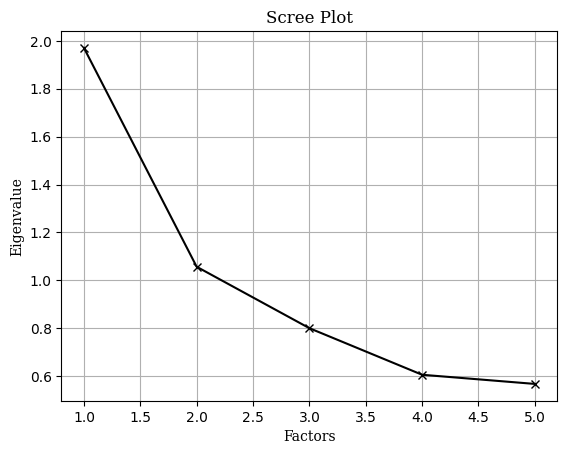

In [196]:
# Plot settings
serif_font = {'fontname': 'serif'}
x_label = 'Factors'
y_label = 'Eigenvalue'
title = 'Scree Plot'

# Scree plot
plt.plot(range(1, scaled_features.shape[1] + 1), ev, marker='x', linestyle='-', color='black')
plt.title(title, **serif_font)
plt.xlabel(x_label, **serif_font)
plt.ylabel(y_label, **serif_font)

# Display grid and show plot
plt.grid()
plt.show()


In [197]:
def factor_analysis(n_factors, method, rotation):
    # Factor analysis setup
    fa = FactorAnalyzer(n_factors, rotation=rotation, method=method, use_smc=True)
    fa.fit(scaled_features)
    
    # Define index for factor loadings DataFrame
    feature_names = ['indep_var_D_0', 'indep_var_C_0', 'indep_var_E_0', 'indep_var_F_0', 'indep_var_B_0']
    
    # Create factor loadings DataFrame
    loadings = pd.DataFrame(
        fa.loadings_.round(2), 
        columns=['Factor ' + str(x) for x in range(1, n_factors + 1)],
        index=feature_names
    )
    
    # Create variance DataFrame
    variance_data = pd.DataFrame(
        fa.get_factor_variance(),
        index=['variance', 'proportional_variance', 'cumulative_variance'],
        columns=['Factor ' + str(x) for x in range(1, n_factors + 1)]
    )
    
    # Add communalities to the loadings DataFrame
    loadings.insert(loc=n_factors, column='communalities', value=fa.get_communalities())
    
    # Combine loadings and variance data
    loadings = pd.concat([loadings, variance_data])

    return loadings, fa.phi_

In [198]:
# Define parameters for factor analysis
factor_set_1 = {'n_factors': 2, 'method': 'minres', 'rotation': 'oblimin'}

# Perform factor analysis
factor_set_1['results'], factor_set_1['factor_correlation'] = factor_analysis(**factor_set_1)

# Display results rounded to 2 decimal places
factor_set_1['results'].round(2)


,Factor 1,Factor 2,communalities
indep_var_D_0,-0.01,0.73,0.54
indep_var_C_0,0.07,0.55,0.31
indep_var_E_0,0.70,0.05,0.50
indep_var_F_0,0.45,-0.16,0.22
indep_var_B_0,0.47,0.01,0.22
variance,0.92,0.87,NaN
proportional_variance,0.18,0.17,NaN
cumulative_variance,0.18,0.36,NaN


In [199]:
factor_set_1['factor_correlation'].round(3)

array([[1.   , 0.562],
       [0.562, 1.   ]])

In [200]:
# Create single factor column based on the average of the first set of independent variables
data['single_factor'] = data[INDEPENDENT_VARS[0]].mean(axis=1)

# Generate single factor columns for each month
for i in MONTH_RANGE:
    factor_column = f'single_factor_{i}'
    data[factor_column] = data[INDEPENDENT_VARS[i]].mean(axis=1)


# Regression | Survival | Single Factor

In [201]:
time = 0
formula = f'survived ~ single_factor_{time}'# 

t_port = True
control_var_E = True
control_var_D = True
control_var_B = True
control_var_F = True

formula += "+ t_in_portfolio " if t_port else ""
formula += "+ C(control_var_E, Treatment(1)) " if control_var_E else ""
formula += '+ C(control_var_D, Treatment("B2B"))'if control_var_D else ''
formula += '+ C(control_var_B, Treatment("Other"))' if control_var_B else ''
formula += '+ C(control_var_F, Treatment(1))' if control_var_F else ''


model = smf.logit(formula, data=data) #
results = model.fit(maxiter = 200, method='bfgs')
print()
print(formula)

print()
print(f"Chi Squared = {results.llr.round(2)}, p-value = {results.llr_pvalue.round(3)})")
print()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.364325
         Iterations: 84
         Function evaluations: 87
         Gradient evaluations: 87

survived ~ single_factor_0+ t_in_portfolio + C(control_var_E, Treatment(1)) + C(control_var_D, Treatment("B2B"))+ C(control_var_B, Treatment("Other"))+ C(control_var_F, Treatment(1))

Chi Squared = 38.0, p-value = 0.0)

                           Logit Regression Results                           
Dep. Variable:               survived   No. Observations:                  120
Model:                          Logit   Df Residuals:                      110
Method:                           MLE   Df Model:                            9
Date:                Sun, 17 Nov 2024   Pseudo R-squ.:                  0.3029
Time:                        15:54:54   Log-Likelihood:                -43.719
converged:                       True   LL-Null:                       -62.719
Covariance Type:            nonrobust   LLR p-value:  

# Regression | Survival | 3 independent variables

In [202]:
time = 0
formula = f'survived ~ '#single_factor_{time}'# 

formula += f"+ indep_var_C_{time} "
#formula += f"+ indep_var_A_{time}  "
#formula += f"+ indep_var_B_{time} "
#formula += f"+ indep_var_D_{time} "
formula += f"+ indep_var_F_{time} "
formula += f"+ indep_var_E_{time} "

t_port = True
control_var_E = True
control_var_D = True
control_var_B = True
control_var_F = True

formula += "+ t_in_portfolio " if t_port else ""
formula += "+ C(control_var_E, Treatment(1)) " if control_var_E else ""
formula += '+ C(control_var_D, Treatment("B2B"))'if control_var_D else ''
formula += '+ C(control_var_B, Treatment("Other"))' if control_var_B else ''
formula += '+ C(control_var_F, Treatment(1))' if control_var_F else ''


model = smf.logit(formula, data=data)
results = model.fit(maxiter=200, method='bfgs')
print()
print(formula)
print()
print(f"Chi Squared = {results.llr.round(2)}, p-value = {results.llr_pvalue.round(3)})")
print()
print(results.summary())

#print(np.exp(results.params))

Optimization terminated successfully.
         Current function value: 0.331101
         Iterations: 91
         Function evaluations: 94
         Gradient evaluations: 94

survived ~ + indep_var_C_0 + indep_var_F_0 + indep_var_E_0 + t_in_portfolio + C(control_var_E, Treatment(1)) + C(control_var_D, Treatment("B2B"))+ C(control_var_B, Treatment("Other"))+ C(control_var_F, Treatment(1))

Chi Squared = 45.97, p-value = 0.0)

                           Logit Regression Results                           
Dep. Variable:               survived   No. Observations:                  120
Model:                          Logit   Df Residuals:                      108
Method:                           MLE   Df Model:                           11
Date:                Sun, 17 Nov 2024   Pseudo R-squ.:                  0.3665
Time:                        15:54:56   Log-Likelihood:                -39.732
converged:                       True   LL-Null:                       -62.719
Covariance Type:    

# Regression | Survival | 3 independent variables excl. controls

In [203]:
time = 0
formula = f'survived ~ '#single_factor_{time}'# 

formula += f"+ indep_var_C_{time} "
#formula += f"+ indep_var_A_{time}  "
#formula += f"+ indep_var_B_{time} "
#formula += f"+ indep_var_D_{time} "
formula += f"+ indep_var_F_{time} "
formula += f"+ indep_var_E_{time} "

t_port = False
control_var_E = False
control_var_D = False
control_var_B = False
control_var_F = False

formula += "+ t_in_portfolio " if t_port else ""
formula += "+ C(control_var_E, Treatment(1)) " if control_var_E else ""
formula += '+ C(control_var_D, Treatment("B2B"))'if control_var_D else ''
formula += '+ C(control_var_B, Treatment("Other"))' if control_var_B else ''
formula += '+ C(control_var_F, Treatment(1))' if control_var_F else ''


model = smf.logit(formula, data=data)
results = model.fit(maxiter=200, method='bfgs')
print()
print(formula)
print()
print(f"Chi Squared = {results.llr.round(2)}, p-value = {results.llr_pvalue.round(3)})")
print()
print(results.summary())

#print(np.exp(results.params))

Optimization terminated successfully.
         Current function value: 0.472457
         Iterations: 18
         Function evaluations: 20
         Gradient evaluations: 20

survived ~ + indep_var_C_0 + indep_var_F_0 + indep_var_E_0 

Chi Squared = 12.05, p-value = 0.007)

                           Logit Regression Results                           
Dep. Variable:               survived   No. Observations:                  120
Model:                          Logit   Df Residuals:                      116
Method:                           MLE   Df Model:                            3
Date:                Sun, 17 Nov 2024   Pseudo R-squ.:                 0.09605
Time:                        15:54:56   Log-Likelihood:                -56.695
converged:                       True   LL-Null:                       -62.719
Covariance Type:            nonrobust   LLR p-value:                  0.007221
                    coef    std err          z      P>|z|      [0.025      0.975]
-------------

# Regression | Follow on Financing | Single Factor

In [223]:


time = 0
formula = f'follow_on ~ single_factor_{time}'# 

#formula += f"+ indep_var_C_{time} "
#formula += f"+ indep_var_A_{time}  "
#formula += f"+ indep_var_B_{time} "
#formula += f"+ indep_var_D_{time} "
#formula += f"+ indep_var_F_{time} "
#formula += f"+ indep_var_E_{time} "

t_port = True
control_var_E = True
control_var_D = True
control_var_B = True
control_var_F = True

formula += "+ t_in_portfolio " if t_port else ""
formula += "+ C(control_var_E, Treatment(1)) " if control_var_E else ""
formula += '+ C(control_var_D, Treatment("B2B"))'if control_var_D else ''
formula += '+ C(control_var_B, Treatment("Other"))' if control_var_B else ''
formula += '+ C(control_var_F, Treatment(1))' if control_var_F else ''


model = smf.logit(formula, data=data) #
results = model.fit(maxiter = 200, method='bfgs')
print()
print(formula)
print()
print()
print(f"Chi Squared = {results.llr.round(2)}, p-value = {results.llr_pvalue.round(3)})")
print()
print(results.summary())
#results.summary( )

Optimization terminated successfully.
         Current function value: 0.577453
         Iterations: 53
         Function evaluations: 56
         Gradient evaluations: 56

follow_on ~ single_factor_0+ t_in_portfolio + C(control_var_E, Treatment(1)) + C(control_var_D, Treatment("B2B"))+ C(control_var_B, Treatment("Other"))+ C(control_var_F, Treatment(1))


Chi Squared = 26.56, p-value = 0.002)

                           Logit Regression Results                           
Dep. Variable:              follow_on   No. Observations:                  120
Model:                          Logit   Df Residuals:                      110
Method:                           MLE   Df Model:                            9
Date:                Sun, 17 Nov 2024   Pseudo R-squ.:                  0.1608
Time:                        16:04:12   Log-Likelihood:                -69.294
converged:                       True   LL-Null:                       -82.577
Covariance Type:            nonrobust   LLR p-val

# Regression | Follow on Financing | 3 independent variables

In [224]:


time = 0
formula = f'follow_on ~ '#single_factor_{time}'# 

formula += f"+ indep_var_C_{time} "
#formula += f"+ traction_pmf_{time} "
#formula += f"+ indep_var_A_{time}  "
#formula += f"+ indep_var_B_{time} "
#formula += f"+ indep_var_D_{time} "
formula += f"+ indep_var_F_{time} "
formula += f"+ indep_var_E_{time} "

#formula += f"+ vd_var_A_{time} "
#formula += f"+ vd_var_B_{time} "
#formula += f"+ vd_var_C_{time} "


t_port = True
control_var_E = True
control_var_D = True
control_var_B = True
control_var_F = True

formula += "+ t_in_portfolio " if t_port else ""
formula += "+ C(control_var_E, Treatment(1)) " if control_var_E else ""
formula += '+ C(control_var_D, Treatment("B2B"))'if control_var_D else ''
formula += '+ C(control_var_B, Treatment("Other"))' if control_var_B else ''
formula += '+ C(control_var_F, Treatment(1))' if control_var_F else ''


model = smf.logit(formula, data=data) #
results = model.fit(maxiter = 200, method='bfgs')
print()
print(formula)
print()
print(f"Chi Squared = {results.llr.round(2)}, p-value = {results.llr_pvalue.round(3)})")
print()
print(results.summary())


Optimization terminated successfully.
         Current function value: 0.502147
         Iterations: 58
         Function evaluations: 61
         Gradient evaluations: 61

follow_on ~ + indep_var_C_0 + indep_var_F_0 + indep_var_E_0 + t_in_portfolio + C(control_var_E, Treatment(1)) + C(control_var_D, Treatment("B2B"))+ C(control_var_B, Treatment("Other"))+ C(control_var_F, Treatment(1))

Chi Squared = 44.64, p-value = 0.0)

                           Logit Regression Results                           
Dep. Variable:              follow_on   No. Observations:                  120
Model:                          Logit   Df Residuals:                      108
Method:                           MLE   Df Model:                           11
Date:                Sun, 17 Nov 2024   Pseudo R-squ.:                  0.2703
Time:                        16:04:23   Log-Likelihood:                -60.258
converged:                       True   LL-Null:                       -82.577
Covariance Type:   

# Regression | Follow-on Financing | Independent variables excl. controls

In [225]:


time = 0
formula = f'follow_on ~ '#single_factor_{time}'# 

formula += f"+ indep_var_C_{time} "
#formula += f"+ indep_var_A_{time}  "
#formula += f"+ indep_var_B_{time} "
#formula += f"+ indep_var_D_{time} "
formula += f"+ indep_var_F_{time} "
formula += f"+ indep_var_E_{time} "


t_port = False
control_var_E = False
control_var_D = False
control_var_B = False
control_var_F = False

formula += "+ t_in_portfolio " if t_port else ""
formula += "+ C(control_var_E, Treatment(1)) " if control_var_E else ""
formula += '+ C(control_var_D, Treatment("B2B"))'if control_var_D else ''
formula += '+ C(control_var_B, Treatment("Other"))' if control_var_B else ''
formula += '+ C(control_var_F, Treatment(1))' if control_var_F else ''


model = smf.logit(formula, data=data) #
results = model.fit(maxiter = 200, method='bfgs')
print()
print(formula)
print()
print(f"Chi Squared = {results.llr.round(2)}, p-value = {results.llr_pvalue.round(3)})")
print()
print(results.summary())


Optimization terminated successfully.
         Current function value: 0.617018
         Iterations: 16
         Function evaluations: 18
         Gradient evaluations: 18

follow_on ~ + indep_var_C_0 + indep_var_F_0 + indep_var_E_0 

Chi Squared = 17.07, p-value = 0.001)

                           Logit Regression Results                           
Dep. Variable:              follow_on   No. Observations:                  120
Model:                          Logit   Df Residuals:                      116
Method:                           MLE   Df Model:                            3
Date:                Sun, 17 Nov 2024   Pseudo R-squ.:                  0.1034
Time:                        16:04:32   Log-Likelihood:                -74.042
converged:                       True   LL-Null:                       -82.577
Covariance Type:            nonrobust   LLR p-value:                 0.0006841
                    coef    std err          z      P>|z|      [0.025      0.975]
------------

# Regression | Follow-on Financing | 3 Independent variables 

In [226]:

# regression for acceptance as relates to SAT score and gpa

time = 0
formula = f'follow_on ~ '#single_factor_{time}'# 

formula += f"+ indep_var_C_{time} "
#formula += f"+ indep_var_A_{time}  "
#formula += f"+ indep_var_B_{time} "
#formula += f"+ indep_var_D_{time} "
formula += f"+ indep_var_F_{time} "
formula += f"+ indep_var_E_{time} "


t_port = True
control_var_E = True
control_var_D = True
control_var_B = True
control_var_F = True

formula += "+ t_in_portfolio " if t_port else ""
formula += "+ C(control_var_E, Treatment(1)) " if control_var_E else ""
formula += '+ C(control_var_D, Treatment("B2B"))'if control_var_D else ''
formula += '+ C(control_var_B, Treatment("Other"))' if control_var_B else ''
formula += '+ C(control_var_F, Treatment(1))' if control_var_F else ''


model = smf.logit(formula, data=data) #
results = model.fit(maxiter = 200, method='bfgs')
print()
print(formula)
print()
print(f"Chi Squared = {results.llr.round(2)}, p-value = {results.llr_pvalue.round(3)})")
print()
print(results.summary())


Optimization terminated successfully.
         Current function value: 0.502147
         Iterations: 58
         Function evaluations: 61
         Gradient evaluations: 61

follow_on ~ + indep_var_C_0 + indep_var_F_0 + indep_var_E_0 + t_in_portfolio + C(control_var_E, Treatment(1)) + C(control_var_D, Treatment("B2B"))+ C(control_var_B, Treatment("Other"))+ C(control_var_F, Treatment(1))

Chi Squared = 44.64, p-value = 0.0)

                           Logit Regression Results                           
Dep. Variable:              follow_on   No. Observations:                  120
Model:                          Logit   Df Residuals:                      108
Method:                           MLE   Df Model:                           11
Date:                Sun, 17 Nov 2024   Pseudo R-squ.:                  0.2703
Time:                        16:04:39   Log-Likelihood:                -60.258
converged:                       True   LL-Null:                       -82.577
Covariance Type:   

# R curve with follow_on

Optimization terminated successfully.
         Current function value: 0.502147
         Iterations: 58
         Function evaluations: 61
         Gradient evaluations: 61
Optimization terminated successfully.
         Current function value: 0.449657
         Iterations: 64
         Function evaluations: 67
         Gradient evaluations: 67
Optimization terminated successfully.
         Current function value: 0.447167
         Iterations: 67
         Function evaluations: 70
         Gradient evaluations: 70
Optimization terminated successfully.
         Current function value: 0.448398
         Iterations: 59
         Function evaluations: 63
         Gradient evaluations: 63
Optimization terminated successfully.
         Current function value: 0.426299
         Iterations: 63
         Function evaluations: 66
         Gradient evaluations: 66
Optimization terminated successfully.
         Current function value: 0.392854
         Iterations: 66
         Function evaluations: 69
  

,pseudo_r_sqr,llr_pvalue,n
1,0.2703,0.0,120
2,0.3466,0.0,120
3,0.3430,0.0,114
4,0.3290,0.0,109
5,0.3491,0.0,102
6,0.3932,0.0,100
7,0.3877,0.0,98
8,0.3929,0.0,91
9,0.4179,0.0,87
10,0.4175,0.0,83


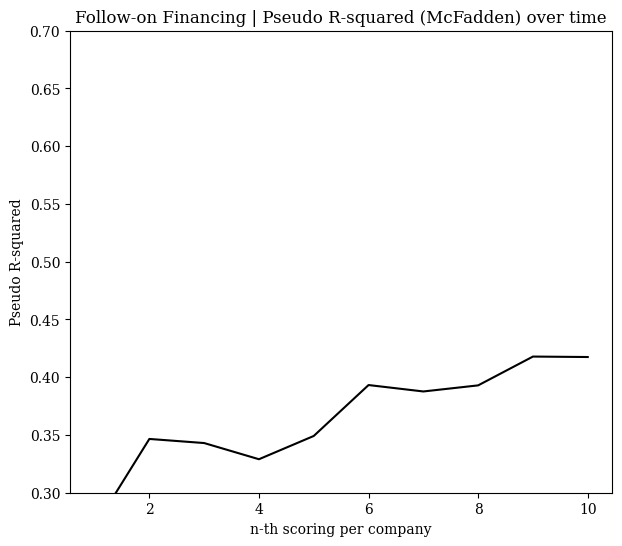

In [229]:
curves = {'pseudo_r_sqr':[], 'llr_pvalue':[], 'n':[]}
for i in range(10):
    try:
        time = i
        formula = f'follow_on ~ '#single_factor_{time}'# 

        formula += f"+ indep_var_C_{time} "
        #formula += f"+ indep_var_A_{time}  "
        #formula += f"+ indep_var_B_{time} "
        #formula += f"+ indep_var_D_{time} "
        formula += f"+ indep_var_F_{time} "
        formula += f"+ indep_var_E_{time} "

        t_port = True
        control_var_E = True
        control_var_D = True
        control_var_B = True
        control_var_F = True

        formula += "+ t_in_portfolio " if t_port else ""
        formula += "+ C(control_var_E, Treatment(1)) " if control_var_E else ""
        formula += '+ C(control_var_D, Treatment("B2B"))'if control_var_D else ''
        formula += '+ C(control_var_B, Treatment("Other"))' if control_var_B else ''
        formula += '+ C(control_var_F, Treatment(1))' if control_var_F else ''


        model = smf.logit(formula, data=data) #
        results = model.fit(maxiter = 200, method='bfgs')
        #c = {'pseudo_r_sqr':results.prsquared, 'llr_pvalue':results.llr_pvalue, 'n':data[f'indep_var_D_{i}'].count()}
        #curves[i] = c
        curves['pseudo_r_sqr'].append(results.prsquared)
        curves['llr_pvalue'].append(results.llr_pvalue)
        curves['n'].append(data[f'indep_var_D_{i}'].count())

    except:
        break

        
curves = pd.DataFrame(curves)
curves.index = range(1,len(curves)+1)

plt.figure(figsize=(7, 6))
plt.plot(curves[['pseudo_r_sqr']],color='black')
plt.title('Follow-on Financing | Pseudo R-squared (McFadden) over time', **serif_font)
plt.ylabel('Pseudo R-squared',**serif_font)
plt.xlabel('n-th scoring per company',**serif_font)
plt.ylim(0.3,0.7)
curves.round(4)

# R curve with survival

Optimization terminated successfully.
         Current function value: 0.331101
         Iterations: 91
         Function evaluations: 94
         Gradient evaluations: 94
Optimization terminated successfully.
         Current function value: 0.325347
         Iterations: 93
         Function evaluations: 96
         Gradient evaluations: 96
Optimization terminated successfully.
         Current function value: 0.309030
         Iterations: 90
         Function evaluations: 93
         Gradient evaluations: 93
Optimization terminated successfully.
         Current function value: 0.291501
         Iterations: 93
         Function evaluations: 96
         Gradient evaluations: 96
Optimization terminated successfully.
         Current function value: 0.289724
         Iterations: 95
         Function evaluations: 98
         Gradient evaluations: 98
Optimization terminated successfully.
         Current function value: 0.261261
         Iterations: 95
         Function evaluations: 98
  

,pseudo_r_sqr,llr_pvalue,n
1,0.3665,0.0,120
2,0.3775,0.0,120
3,0.4245,0.0,114
4,0.4612,0.0,109
5,0.4690,0.0,102
6,0.5155,0.0,100
7,0.5609,0.0,98
8,0.5826,0.0,91
9,0.5823,0.0,87
10,0.4832,0.0,83


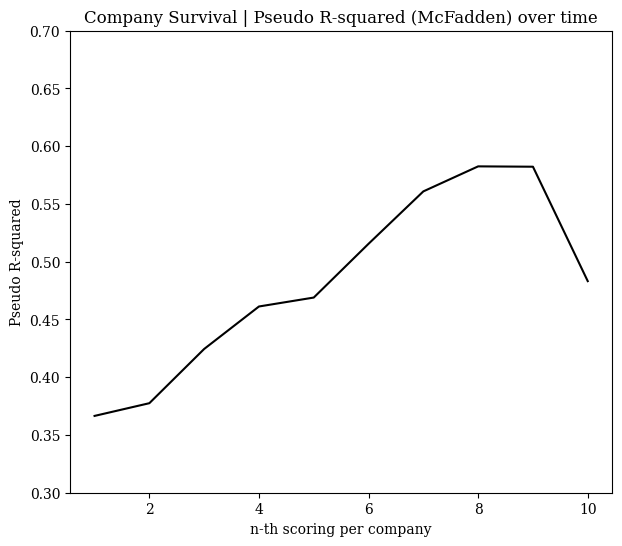

In [231]:
curves = {'pseudo_r_sqr':[], 'llr_pvalue':[], 'n':[]}
for i in range(10):
    try:
        time = i
        formula = f'survived ~ '#single_factor_{time}'# 

        formula += f"+ indep_var_C_{time} "
        #formula += f"+ indep_var_A_{time}  "
        #formula += f"+ indep_var_B_{time} "
        #formula += f"+ indep_var_D_{time} "
        formula += f"+ indep_var_F_{time} "
        formula += f"+ indep_var_E_{time} "

        t_port = True
        control_var_E = True
        control_var_D = True
        control_var_B = True
        control_var_F = True

        formula += "+ t_in_portfolio " if t_port else ""
        formula += "+ C(control_var_E, Treatment(1)) " if control_var_E else ""
        formula += '+ C(control_var_D, Treatment("B2B"))'if control_var_D else ''
        formula += '+ C(control_var_B, Treatment("Other"))' if control_var_B else ''
        formula += '+ C(control_var_F, Treatment(1))' if control_var_F else ''


        model = smf.logit(formula, data=data) #
        results = model.fit(maxiter = 200, method='bfgs')
        #c = {'pseudo_r_sqr':results.prsquared, 'llr_pvalue':results.llr_pvalue, 'n':data[f'indep_var_D_{i}'].count()}
        #curves[i] = c
        curves['pseudo_r_sqr'].append(results.prsquared)
        curves['llr_pvalue'].append(results.llr_pvalue)
        curves['n'].append(data[f'indep_var_D_{i}'].count())

    except:
        break
    #print(curves)
        
curves = pd.DataFrame(curves)
curves.index = range(1,len(curves)+1)

plt.figure(figsize=(7, 6))

plt.plot(curves[['pseudo_r_sqr']],color='black')
plt.title('Company Survival | Pseudo R-squared (McFadden) over time', **serif_font)
plt.ylabel('Pseudo R-squared',**serif_font)
plt.xlabel('n-th scoring per company',**serif_font)

plt.ylim(0.3,.7)
curves.round(4)

# Time to event analysis (Survival analysis)

/var/folders/98/1pfl70l56658vfvt0cqc09040000gn/T/ipykernel_54889/42244001.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  operation_shutdown['event_observed'] = operation_shutdown.applymap(lambda row: 0 if np.isnan(row)==True else 1)


Median time to survive: 32.0 months
After 0 m, P(survived) is 100.00%
After 3 m, P(survived) is 100.00%
After 6 m, P(survived) is 98.13%
After 9 m, P(survived) is 97.07%
After 12 m, P(survived) is 94.77%
After 18 m, P(survived) is 90.68%
After 24 m, P(survived) is 76.17%
After 30 m, P(survived) is 55.98%
After 36 m, P(survived) is 38.88%


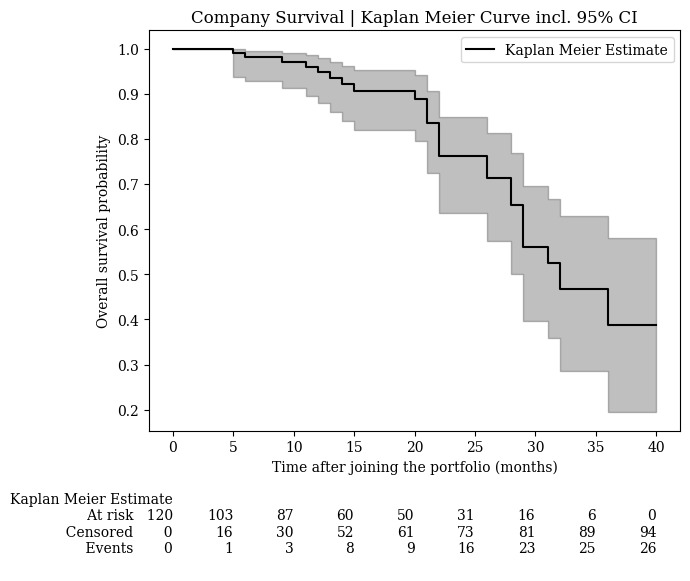

In [232]:
operation_shutdown = pd.DataFrame()
operation_shutdown['durations'] = data.shutdown_t
operation_shutdown['event_observed'] = operation_shutdown.applymap(lambda row: 0 if np.isnan(row)==True else 1)
#operation_shutdown['durations'] = operation_shutdown.applymap(lambda row: 39 if np.isnan(row) == True else row)
operation_shutdown['durations'] = data.apply(lambda row: row.t_in_portfolio if np.isnan(row.shutdown_t) == True else row.shutdown_t, axis=1)
operation_shutdown['control_var_D'] = data['control_var_D']
operation_shutdown['control_var_E'] = data['control_var_E']
kmf = KaplanMeierFitter() 

kmf.fit(operation_shutdown['durations'], operation_shutdown['event_observed'],label='Kaplan Meier Estimate')

plt.figure(figsize=(7, 6))
matplotlib.rcParams.update({'font.family': 'Serif'})
plt.title('Company Survival | Kaplan Meier Curve incl. 95% CI')

ax = kmf.plot(ci_show=True, at_risk_counts=True, color = 'black') ## ci_show is meant for Confidence interval, since our data set is too tiny, thus i am not showing it.
ax.set_xlabel("Time after joining the portfolio (months)", **serif_font)
ax.set_ylabel('Overall survival probability', **serif_font)



print(f"Median time to survive: {kmf.median_survival_time_} months")

for i in [0,3,6,9,12,18,24,30,36]:
    print(f"After {i} m, P(survived) is", '{:2.2f}%'.format(kmf.predict(i).round(4) * 100))


# Kaplan Meier Curve | Follow-on financing

Median time to receive follow_on funding: 13.0 months
After 0 m, P(no financing) is 100.00%
After 3 m, P(no financing) is 97.50%
After 6 m, P(no financing) is 80.15%
After 9 m, P(no financing) is 62.03%
After 12 m, P(no financing) is 51.00%
After 18 m, P(no financing) is 33.85%
After 24 m, P(no financing) is 28.84%
After 30 m, P(no financing) is 28.84%
After 36 m, P(no financing) is 28.84%


/var/folders/98/1pfl70l56658vfvt0cqc09040000gn/T/ipykernel_54889/119451286.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  follow_on['event_observed'] = follow_on.applymap(lambda row: 0 if np.isnan(row)==True else 1)


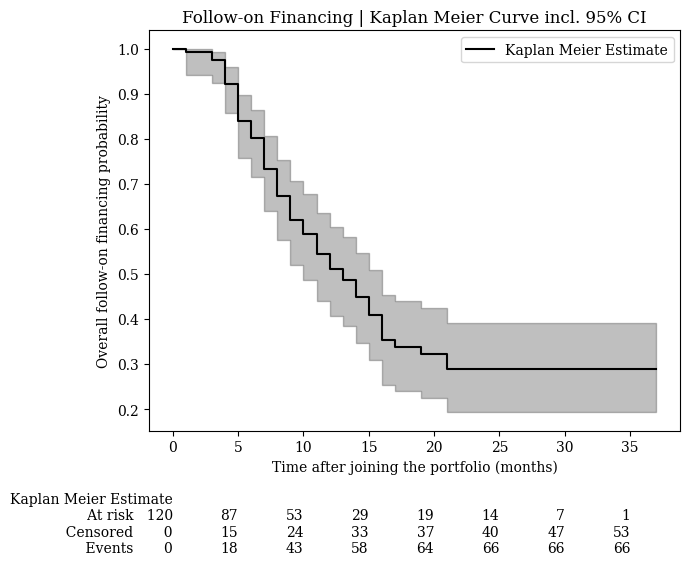

In [211]:
follow_on = pd.DataFrame()
follow_on['durations'] = data.t_follow_on
follow_on['event_observed'] = follow_on.applymap(lambda row: 0 if np.isnan(row)==True else 1)
#follow_on['durations'] = follow_on.applymap(lambda row: 39 if np.isnan(row) == True else row)
follow_on['durations'] = data.apply(lambda row: row.t_in_portfolio if np.isnan(row.t_follow_on) == True else row.t_follow_on, axis=1)
follow_on['control_var_E'] = data['control_var_E']
follow_on['control_var_F'] = data['control_var_F']
follow_on['control_var_D'] = data['control_var_D']
follow_on['round_name'] = data['round_name'].copy()
for var in INDEPENDENT_VARS[0]:
    follow_on[var] = data[var]
follow_on

kmf = KaplanMeierFitter() 

kmf.fit(follow_on['durations'], follow_on['event_observed'],label='Kaplan Meier Estimate')

plt.figure(figsize=(7, 6))
plt.title('Follow-on Financing | Kaplan Meier Curve incl. 95% CI',  **serif_font)
matplotlib.rcParams.update({'font.family': 'Serif'})
ax = kmf.plot(ci_show=True, at_risk_counts=True, color = 'black') ## ci_show is meant for Confidence interval, since our data set is too tiny, thus i am not showing it.
ax.set_xlabel("Time after joining the portfolio (months)", **serif_font)
ax.set_ylabel("Overall follow-on financing probability", **serif_font)
#ax.legend(prop={'family':'Serif'})

#textbox = dict(horizontalalignment = 'left', verticalalignment = 'bottom', fontname = 'Arial', fontsize = 18)




print(f"Median time to receive follow_on funding: {kmf.median_survival_time_} months")
for i in [0,3,6,9,12,18,24,30,36]:
    print(f"After {i} m, P(no financing) is", '{:2.2f}%'.format(kmf.predict(i).round(4) * 100))



In [234]:
from lifelines.statistics import pairwise_logrank_test
# Helper function for plotting Kaplan-Meier curves at the covariate level
def plot_km(df, col):
    ax = plt.subplot(111)
    ax.set_title(col)
    for r in df[col].unique():
        ix = df[col] == r
        kmf.fit(df[ix]['durations'], df[ix]['event_observed'],label=r)
        kmf.plot(ax=ax, ci_show=False)

# Helper function for printing out Log-rank test results
def print_logrank(df, col):
    log_rank = pairwise_logrank_test(df['durations'], df[col], df['event_observed'])
    return log_rank.summary.round(2)

,,test_statistic,p,-log2(p)
0.0,1.0,0.04,0.83,0.26


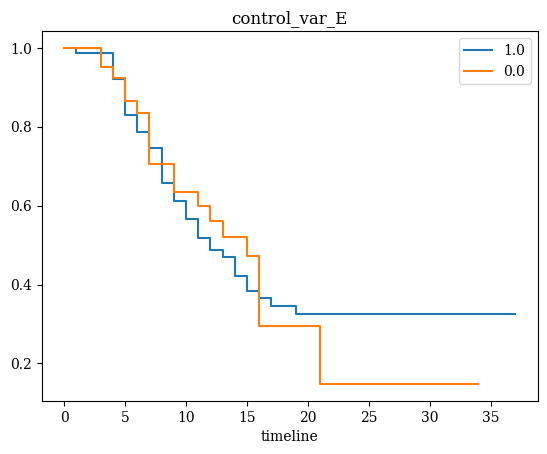

In [235]:
plot_km(follow_on, 'control_var_E')
print_logrank(follow_on, 'control_var_E')

,,test_statistic,p,-log2(p)
0,1,0.45,0.5,1.0


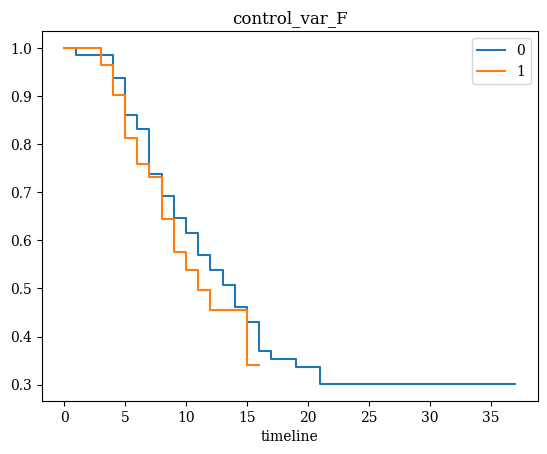

In [236]:
plot_km(follow_on, 'control_var_F')
print_logrank(follow_on, 'control_var_F')

,,test_statistic,p,-log2(p)
0.0,1.0,0.43,0.51,0.96


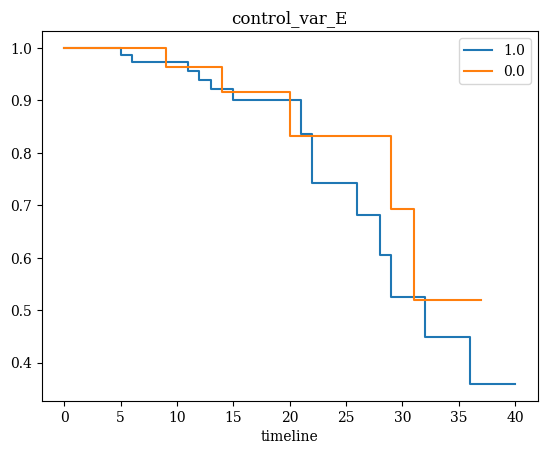

In [237]:
plot_km(operation_shutdown, 'control_var_E')
print_logrank(operation_shutdown, 'control_var_E')

## Cox Regression
https://datatab.net/premium/packages
https://medium.com/the-researchers-guide/survival-analysis-in-python-km-estimate-cox-ph-and-aft-model-5533843c5d5d

matches https://datatab.net/statistics-calculator/survival-analysis/cox-regression

# Cox PH | Follow-on financing | Single factor

In [238]:
from lifelines import CoxPHFitter
cph = CoxPHFitter()

follow_on_coxph = data[['single_factor']].copy()

follow_on_coxph[['durations','event_observed']] = follow_on[['durations','event_observed']]#+['control_var_D_B2B2C', 'control_var_D_B2C']].copy()

#follow_on_coxph[['control_var_D_B2B2C', 'control_var_D_B2C']] = follow_on[['control_var_D_B2B2C', 'control_var_D_B2C']].copy()

follow_on_coxph['t_in_portfolio'] = data['t_in_portfolio']

#follow_on_less_var['t_in_portfolio'] = data['t_in_portfolio']

cph.fit(follow_on_coxph, duration_col = 'durations', event_col = 'event_observed', strata = ['t_in_portfolio'])#, 'indep_var_E_0'])#,strata=['control_var_F'])
cph.print_summary()


<lifelines.CoxPHFitter: fitted with 120 total observations, 54 right-censored observations>
             duration col = 'durations'
                event col = 'event_observed'
                   strata = t_in_portfolio
      baseline estimation = breslow
   number of observations = 120
number of events observed = 66
   partial log-likelihood = -74.38
         time fit was run = 2024-11-17 15:06:51 UTC

---
               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                      
single_factor  0.31      1.36      0.19           -0.06            0.68                0.94                1.98

               cmp to    z    p  -log2(p)
covariate                                
single_factor    0.00 1.63 0.10      3.27
---
Concordance = 0.57
Partial AIC = 150.76
log-likelihood ratio test = 2.84 on 1 df
-log2(p) of ll-ratio test = 3.45

In [239]:
cph.check_assumptions(follow_on_coxph, p_value_threshold = 0.05)

Proportional hazard assumption looks okay.


[]

# Cox PH | Follow-on financing | All independent variables

In [240]:
from lifelines import CoxPHFitter
cph = CoxPHFitter()


follow_on_less_var = follow_on[[f'indep_var_C_{0}', f'indep_var_E_{0}', f'indep_var_F_{0}','durations','event_observed']].copy()#+['control_var_D_B2B2C', 'control_var_D_B2C']].copy()

follow_on_less_var['t_in_portfolio'] = data['t_in_portfolio'].copy()

cph.fit(follow_on_less_var, duration_col = 'durations', event_col = 'event_observed', strata = ['t_in_portfolio'])#, 'indep_var_E_0'])#,strata=['control_var_F'])
cph.print_summary()


<lifelines.CoxPHFitter: fitted with 120 total observations, 54 right-censored observations>
             duration col = 'durations'
                event col = 'event_observed'
                   strata = t_in_portfolio
      baseline estimation = breslow
   number of observations = 120
number of events observed = 66
   partial log-likelihood = -71.13
         time fit was run = 2024-11-17 15:06:58 UTC

---
               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                      
indep_var_C_0  0.28      1.33      0.12            0.05            0.51                1.06                1.67
indep_var_E_0  0.11      1.12      0.13           -0.14            0.36                0.87                1.43
indep_var_F_0  0.02      1.02      0.15           -0.28            0.32                0.76                1.38

               cmp to    z    p  -log2(p)
covariate                                
indep_var_C_0    0.00 2.43 0.02      6.05
indep_var_E_0    0.00 0.87 0.38      1.38
indep_var_F_0    0.00 0.13 0.90      0.16
---
Concordance = 0.64
Partial AIC = 148.26
log-likelihood ratio test = 9.35 on 3 df
-log2(p) of ll-ratio test = 5.33

In [241]:
cph.check_assumptions(follow_on_less_var, p_value_threshold = 0.05)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 120 total observations, 54 right-censored observations>
         test_name = proportional_hazard_test

---
                    test_statistic    p  -log2(p)
indep_var_C_0 km              4.02 0.04      4.48
              rank            0.29 0.59      0.77
indep_var_E_0 km              1.07 0.30      1.73
              rank            3.87 0.05      4.35
indep_var_F_0 km              1.15 0.28      1.82
              rank            0.18 0.67      0.58



1. Variable 'indep_var_C_0' failed the non-proportional test: p-value is 0.0449.

   Advice 1: the functional form of the variable 'indep_var_C_0' might be incorrect. That is, there
may be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'indep_var_C_0' using pd.cut, and then specify it in
`strata=['indep_var_C_0', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'indep_var_E_0' failed the non-proportional test: p-value is 0.0492.

   Advice 1: the functional form of the variable 'indep_var_E_0' might be incorrect. That is, there
may be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below 

[]

# Cox PH | Survival | Independent variable C

In [242]:

cph = CoxPHFitter()

survival_coxph = data[['indep_var_C_0','t_in_portfolio']].copy()
                      
survival_coxph[['durations','event_observed']] = operation_shutdown[['durations','event_observed']]



cph.fit(survival_coxph, duration_col = 'durations', event_col = 'event_observed', strata = ['t_in_portfolio'])#,strata=['control_var_F'])
print(cph.log_likelihood_ratio_test())
cph.print_summary()

<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 1
        test_name = log-likelihood ratio test

---
 test_statistic    p  -log2(p)
           4.01 0.05      4.46


<lifelines.CoxPHFitter: fitted with 120 total observations, 94 right-censored observations>
             duration col = 'durations'
                event col = 'event_observed'
                   strata = t_in_portfolio
      baseline estimation = breslow
   number of observations = 120
number of events observed = 26
   partial log-likelihood = -30.45
         time fit was run = 2024-11-17 15:07:12 UTC

---
               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                      
indep_var_C_0 -0.25      0.78      0.13           -0.51            0.00                0.60                1.00

               cmp to     z    p  -log2(p)
covariate                                 
indep_var_C_0    0.00 -1.96 0.05      4.32
---
Concordance = 0.62
Partial AIC = 62.91
log-likelihood ratio test = 4.01 on 1 df
-log2(p) of ll-ratio test = 4.46

In [221]:
cph.check_assumptions(survival_coxph, p_value_threshold = 0.05)

Proportional hazard assumption looks okay.


[]